In [1]:
import pandas as pd
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline 

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [82]:
train_df = pd.read_csv('Data/train_df_0313.csv')
y_train = pd.read_csv('Data/y_train_0313.csv')
valid_df = pd.read_csv('Data/valid_df_0313.csv')
y_valid = pd.read_csv('Data/y_valid_0313.csv')

In [85]:
IDcol = 'Player_ID'
target = "NewGameFanPTs"
predictors = [x for x in train_df.columns if x not in [target, IDcol, 'fullName','Rank_dup']]

In [86]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [89]:
def modelfit(alg, train_df,y_train,predictors,useTrainCV=True, cv_folds=3,early_stopping_rounds=50): 
    #cross validation for selecting the number of estomators(trees)
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train_df[predictors].values, label= y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,\
                          early_stopping_rounds=early_stopping_rounds, show_progress=True)
        alg.set_params(n_estimators=cvresult.shape[0])
        print "number of estomators : "+ str(cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(train_df[predictors], y_train, eval_metric='rmse')
                
    return alg

In [131]:
xgb1 = XGBRegressor(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=3,
        min_child_weight=8,
        gamma=3,
        objective= 'reg:linear',
        subsample=0.95,
        colsample_bytree=0.7,
        nthread=-1,
        scale_pos_weight=1,
        reg_alpha=0.9753,
        reg_lambda = 0.7083,
        seed=27)
model1 = modelfit(xgb1, train_df, y_train, predictors)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-rmse:24.172467+0.112173473846	cv-train-rmse:24.168204+0.0466935464277
[1]	cv-test-rmse:22.1777596667+0.120004069068	cv-train-rmse:22.1684113333+0.0329733064294
[2]	cv-test-rmse:20.416215+0.119144962884	cv-train-rmse:20.400468+0.0248184089068
[3]	cv-test-rmse:18.868921+0.117097978414	cv-train-rmse:18.8516843333+0.0222227928988
[4]	cv-test-rmse:17.509451+0.111682329939	cv-train-rmse:17.485916+0.0182428495033
[5]	cv-test-rmse:16.3282706667+0.113624207181	cv-train-rmse:16.2969216667+0.0100884192463
[6]	cv-test-rmse:15.2973146667+0.10925826378	cv-train-rmse:15.257802+0.0069159367165
[7]	cv-test-rmse:14.4104203333+0.104489014071	cv-train-rmse:14.3633646667+0.00485324567229
[8]	cv-test-rmse:13.6435536667+0.0998589157439	cv-train-rmse:13.5870303333+0.00308684329948
[9]	cv-test-rmse:12.9857263333+0.0953641252475	cv-train-rmse:12.9209296667+0.00857969278134
[10]	cv-test-rmse:12.4250836667+0.093321014212	cv-train-rmse:12.3526016

number of estomators : 79


[128]	cv-test-rmse:9.61406433333+0.0526699222285	cv-train-rmse:8.85462266667+0.0274364029388
Stopping. Best iteration: 78


In [134]:
with open('Data/xgboost_model1_0313.pickle', 'wb') as handle:
  pickle.dump(model1,handle)

##Model evaluation

In [91]:
def get_performance(xgbmodel,train_df, y_train, valid_df, y_valid,predictors):
    train_predictions = xgbmodel.predict(train_df[predictors])
    print "\nModel Report"
    print "RMSE(Train) : %.4g" % metrics.mean_squared_error(y_train, train_predictions)**0.5
    print "R^2 Score (Train): %f" % metrics.r2_score(y_train, train_predictions)
    test_result = xgbmodel.predict(valid_df[predictors])
    print "RMSE(Test) : %.4g" % metrics.mean_squared_error(y_valid, test_result)**0.5
    print 'R^2 Score (Test): %f' % metrics.r2_score(y_valid, test_result)

In [132]:
get_performance(model1,train_df, y_train, valid_df, y_valid, predictors)


Model Report
RMSE(Train) : 9.201
R^2 Score (Train): 0.540187
RMSE(Test) : 9.769
R^2 Score (Test): 0.477352


In [137]:
from ggplot import *
def plot_predictions(xgbmodel,predictors,pred_label,data,data_label): 
    data[pred_label] = xgbmodel.predict(data[predictors])
    data['NewGameFanPTs'] = data_label
    plot_obj = ggplot(aes(x='NewGameFanPTs', y=pred_label, colour='Rank_dup'), data=data)+geom_point()+\
    ggtitle(pred_label+" Prediction Performance")+ geom_abline(intercept = 0, slope = 1)
    return(plot_obj)

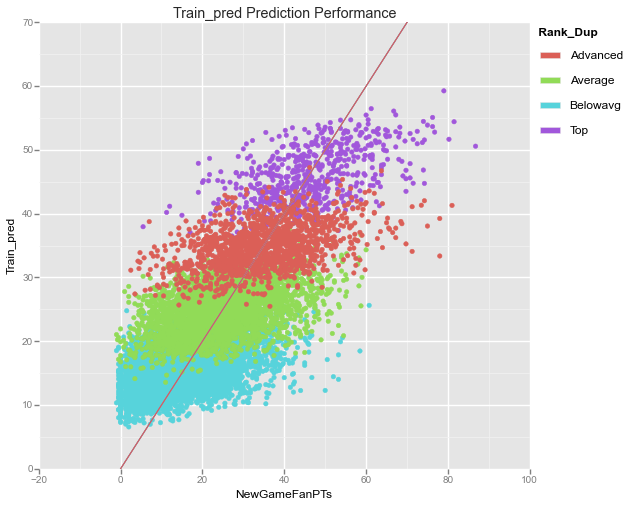

<ggplot: (285747925)>

In [138]:
plot_predictions(model1,predictors,'Train_pred',train_df,y_train)

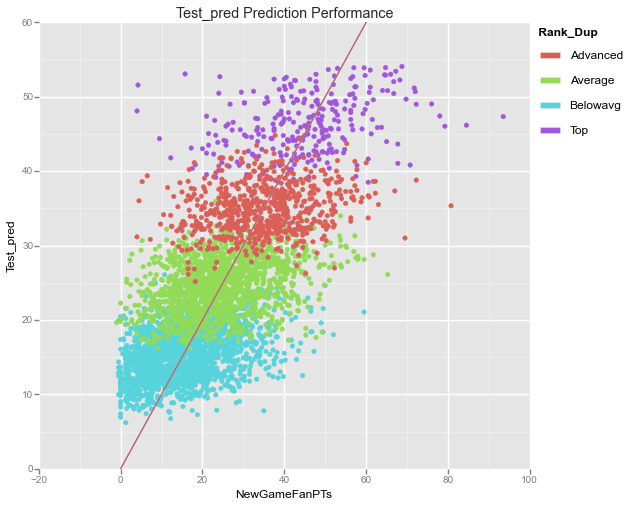

<ggplot: (279054765)>

In [139]:
plot_predictions(model1,predictors,'Test_pred',valid_df,y_valid)

#Testing

In [160]:
test_df = pd.read_csv('Data/experiment_test_df_0313.csv')

In [158]:
test_df.head().transpose()

,0,1,2,3,4
fullName,Matthew Dellavedova,Timofey Mozgov,Tiago Splitter,J.R. Smith,Dennis Schroder
Player_ID,203521,202389,201168,2747,203471
LastFanPTs,14.75,6,13.25,30.5,-1
AvgFanPTs,19.10345,14.13333,12.44444,22.27917,22.76562
AvgPTS,8.068966,6.4,5.583333,12.55,11.0625
LastPT,11,2,5,17,0
AvgMIN,25.77586,17.55,16.05556,30.86667,20.48438
LastMIN,17,13,15,34,3
AvgFGM,2.948276,2.766667,2.25,4.633333,4.15625
LastFGM,4,1,1,5,0


In [162]:
test_predictions = model1.predict(test_df[predictors])

In [164]:
test_df.columns

Index([u'fullName', u'Player_ID', u'LastFanPTs', u'AvgFanPTs', u'AvgPTS',
       u'LastPT', u'AvgMIN', u'LastMIN', u'AvgFGM', u'LastFGM', 
       ...
       u'OpponentTeam_CHI', u'OpponentTeam_SAS', u'OpponentTeam_MEM',
       u'OpponentTeam_WAS', u'OpponentTeam_DAL', u'GameMonth_1',
       u'GameMonth_2', u'GameMonth_11', u'GameMonth_12', u'GameMonth_10'],
      dtype='object', length=110)

In [165]:
test_result_df = pd.DataFrame({'fullName':test_df['fullName'],'Player_ID':test_df['Player_ID'],\
                           'prediction':test_predictions})

In [176]:
test_result_df.head()

,Player_ID,fullName,prediction
0,203521,Matthew Dellavedova,16.859592
1,202389,Timofey Mozgov,12.560592
2,201168,Tiago Splitter,12.859308
3,2747,J.R. Smith,21.988348
4,203471,Dennis Schroder,16.945889


###We need to combine our predictions with salary costs as inputs for our second stage optimizer problem.

In [ ]:
def match_salary(result_df):

In [169]:
with open('Data/SalaryHistory031216/2016-03-12.csv','rb') as data_file:
    playcost_0312 = pd.read_csv(data_file,sep=";")

In [170]:
playcost_0312.shape

(297, 14)

In [171]:
playcost_0312['DK Salary'] = playcost_0312['DK Salary'].astype(str).map(
    lambda ele: ele if ele == 'nan' else int(ele.replace('$', '').replace(',', '')))

In [223]:
playcost_0312['fullName'] = playcost_0312['Name'].astype(str).map(lambda nn: nn.split(', ')[1]+' '\
                                                      + nn.split(', ')[0])

In [229]:
cost_namels = playcost_0312.fullName

In [225]:
ntest_result_df = pd.merge(test_result_df,playcost_0312[['fullName','DK Salary']],on='fullName')

In [180]:
playcost_0312[['fullName','DK Salary']].shape

(297, 2)

In [181]:
test_result_df.shape

(110, 3)

In [227]:
ntest_result_df.shape

(33, 4)

In [228]:
ntest_result_df

,Player_ID,fullName,prediction,DK Salary
0,201168,Tiago Splitter,12.859308,3000
1,203471,Dennis Schroder,16.945889,4200
2,201143,Al Horford,34.201908,6700
3,201952,Jeff Teague,30.251165,6000
4,2594,Kyle Korver,20.583971,3800
5,200757,Thabo Sefolosha,18.483992,3200
6,200794,Paul Millsap,39.195370,7700
7,203118,Mike Scott,11.972397,3000
8,203145,Kent Bazemore,25.119061,5100
9,2746,Josh Smith,13.326095,3500
